In [3]:
import numpy as np
import pandas as pd

In [47]:
dff = pd.read_csv("data/train.csv")
dff_test = pd.read_csv("data/test.csv")

In [6]:
metadata = pd.read_csv("data/item_metadata.csv")

In [7]:
cols=["user_id","session_id","timestamp","step","action_type","reference","platform","city","device","current_filters","impressions","prices","interactions"]
df = pd.read_csv("data/train.groupby.csv", sep="\t", names=cols)
df_val = pd.read_csv("data/val.groupby.csv", sep="\t", names=cols)
df_test = pd.read_csv("data/test.groupby.csv", sep="\t", names=cols)

In [26]:
# interactions = []
for idx, row in df.iterrows():
#     imp.append(len(row['impressions'].split("|")))
    interaction = row['interactions'].split("|") if type(
                    row['interactions']) == str else []
    interactions.append(len(interaction))
    

In [91]:
clicks = dff[dff.action_type == "clickout item"]

In [124]:
clicks['label'] = click_dist

/Users/jarana/anaconda3/envs/recsys2019/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [128]:
price_dist = clicks['prices'].apply(lambda x : np.mean([int(i) for i in x.split("|")]))

In [131]:
clicks['price_mean'] = price_dist

/Users/jarana/anaconda3/envs/recsys2019/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [142]:
len(clicks)

1586586

In [143]:
session_first_row = dff[dff.session_id.isin(clicks['session_id'])].groupby("session_id").first()

In [150]:
session_first_row['first_time'] = session_first_row['timestamp']

In [152]:
session_first_row['first_time'].head()

session_id
00000510f1adc   2018-11-01 09:21:27
00003f3b20954   2018-11-01 18:41:36
000056cd97ce2   2018-11-06 05:57:26
000066611146f   2018-11-04 11:51:45
0000be39860d7   2018-11-01 20:05:52
Name: first_time, dtype: datetime64[ns]

In [205]:
clicks.label

0           9
1           5
2           0
3          15
4          15
5           4
6           7
7          23
8           1
9          19
10          9
11         10
12          0
13          0
14         12
15          0
16          3
17          0
18          0
19          9
20          6
21          7
22         16
23         16
24          0
25          6
26          6
27          2
28         17
29         17
           ..
1586556     8
1586557    14
1586558    14
1586559     1
1586560    24
1586561     4
1586562     0
1586563    21
1586564     5
1586565     0
1586566     2
1586567     5
1586568     5
1586569    16
1586570    21
1586571     2
1586572     3
1586573     6
1586574     6
1586575     0
1586576     0
1586577     0
1586578     2
1586579     6
1586580     0
1586581     0
1586582    20
1586583     0
1586584    20
1586585     3
Name: label, Length: 1586586, dtype: int64

In [155]:
clicks = pd.merge(clicks, session_first_row['first_time'], on='session_id')

In [158]:
pd.Timedelta(clicks['timestamp'] - clicks['first_time']).seconds / 3600.0

ValueError: Value must be Timedelta, string, integer, float, timedelta or convertible

In [166]:
clicks['duration'] = (clicks['timestamp'] - clicks['first_time']).dt.total_seconds()

In [174]:
clicks['isFilter'] = clicks['current_filters'].isna() * 1
tmp = ["mobile", "desktop", "tablet"]
clicks['device'] = clicks['device'].apply(lambda x : tmp.index(x))

(1586586, 6)

In [177]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [178]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [197]:
from keras.utils.np_utils import to_categorical
# load dataset
dataset = clicks[['step', 'duration', 'device', 'price_mean', 'isFilter', 'label' ]].values
X = dataset[:,0:5].astype(float)
Y = to_categorical(dataset[:,5], 26)

In [202]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(dataset[:,5]),
                                                 dataset[:,5])

In [206]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=5, activation='relu'))
    model.add(Dense(26, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=256, verbose=1)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

results = cross_val_score(estimator, X, Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/200
1427927/1427927 [==============================] - 9s 6us/step - loss: 3.8593 - acc: 0.2914
Epoch 2/200
1427927/1427927 [==============================] - 9s 6us/step - loss: 3.2544 - acc: 0.3003
Epoch 3/200
1427927/1427927 [==============================] - 9s 6us/step - loss: 3.0818 - acc: 0.3026
Epoch 4/200
1427927/1427927 [==============================] - 9s 6us/step - loss: 2.8414 - acc: 0.3088
Epoch 5/200
1427927/1427927 [==============================] - 9s 6us/step - loss: 2.6959 - acc: 0.3138
Epoch 6/200
1427927/1427927 [==============================] - 9s 6us/step - loss: 2.5985 - acc: 0.3185
Epoch 7/200
1427927/1427927 [==============================] - 9s 7us/step - loss: 2.5575 - acc: 0.3223
Epoch 8/200
1427927/1427927 [==============================] - 10s 7us/step - loss: 2.5570 - acc: 0.3223
Epoch 9/200
1427927/1427927 [==============================] - 10s 7us/step - loss: 2.5568 - acc: 0.3223
Epoch 10/200
1427927/1427927 [==============================] 

KeyboardInterrupt: 

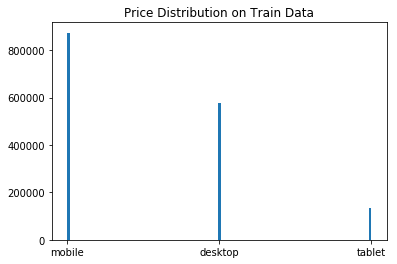

In [134]:
plt.hist(clicks['device'].tolist(), bins='auto')  # arguments are passed to np.histogram
plt.title("Price Distribution on Train Data")
plt.show()

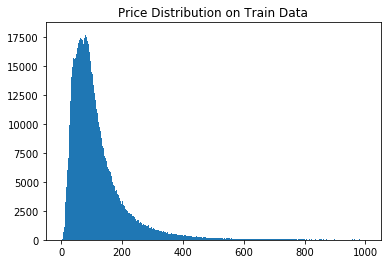

In [130]:
plt.hist(price_dist, bins='auto', range=(0,1000))  # arguments are passed to np.histogram
plt.title("Price Distribution on Train Data")
plt.show()

In [95]:
from tqdm.autonotebook import tqdm

click_dist = []
for idx, row in clicks.iterrows():
    rank = [int(i) for i in row['impressions'].split("|")]
    gtItem = int(row['reference'])
    if gtItem in rank:
        click_dist.append(rank.index(gtItem))
    else:
        click_dist.append(25)


/Users/jarana/anaconda3/envs/recsys2019/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


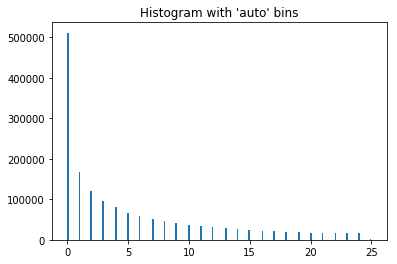

In [99]:
plt.hist(click_dist, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [100]:
len(clicks)

1586586

In [105]:
clicks

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
13,00RL8Z82B2Z1,aff3928535f48,2018-11-01 01:59:03,14,clickout item,109038,AU,"Sydney, Australia",mobile,NaN,3400638|1253714|3367857|5100540|1088584|666916...,95|66|501|112|95|100|101|72|82|56|56|143|70|25...
15,00RL8Z82B2Z1,aff3928535f48,2018-11-01 02:14:45,16,clickout item,1257342,AU,"Sydney, Australia",mobile,NaN,55109|129343|54824|2297972|109014|1257342|1031...,162|25|150|143|101|49|118|131|18|100|101|143|5...
115,02SRUT1NQYH1,3599a6f709eab,2018-11-01 09:17:44,35,clickout item,2795374,FI,"Krakow, Poland",mobile,NaN,2795374|5582964|1088390|2781070|1258068|127196...,64|54|36|121|76|81|92|40|73|52|98|104|56|414|6...
121,03K8AXBL4BX2,ec139e10b9238,2018-11-01 19:25:22,6,clickout item,1032816,UK,"London, United Kingdom",desktop,NaN,12693|46363|81657|18448|47687|152913|18417|927...,104|92|100|103|102|104|72|85|81|75|107|86|98|8...
122,03K8AXBL4BX2,ec139e10b9238,2018-11-01 19:30:52,7,clickout item,1032816,UK,"London, United Kingdom",desktop,NaN,12693|46363|81657|18448|47687|152913|18417|927...,104|92|100|103|102|104|72|85|81|75|107|86|98|8...
176,03P4VFKK12UO,325fafb5fa450,2018-11-01 21:25:00,54,clickout item,65685,US,"Bakersfield, USA",desktop,Very Good Rating|5 Star|4 Star|Hotel|Motel|Res...,1306936|56482|2842358|6881276|65685|63259|6539...,178|104|110|94|57|96|46|61|48|35|50|38|59|44|5...
177,03P4VFKK12UO,325fafb5fa450,2018-11-01 21:25:38,55,clickout item,1320460,US,"Bakersfield, USA",desktop,Very Good Rating|5 Star|4 Star|Hotel|Motel|Res...,1306936|56482|2842358|6881276|65685|63259|6539...,178|104|110|94|57|96|46|61|48|35|50|38|59|44|5...
180,0473FZ8UNXRS,bcc452f3350eb,2018-11-01 08:55:32,3,clickout item,3143258,AU,"Legian, Indonesia",desktop,NaN,1258184|3866722|8929970|2315702|116619|1511641...,51|43|69|49|62|50|55|42|87|46|43|114|194|50|19...
181,066TUPQWUEV5,7157899be2839,2018-11-01 20:04:39,1,clickout item,2552514,MX,"Mazamitla, Mexico",mobile,NaN,2349076|2552514|7159866|3898458|1846017|725025...,54|39|55|51|41|94|24|38|59|24|72|314|46|40|183...
184,06S61EKCW1JY,22b9deb2da8f7,2018-11-01 12:27:38,1,clickout item,110591,FR,"Alicante, Spain",tablet,NaN,6721|6724|40109|147227|80983|6719|40718|119405...,36|45|99|48|49|50|49|56|40|63|35|95|40|78|132|...


In [102]:
click_dist = []
for idx, row in clicks.iterrows():
    rank = [int(i) for i in row['impressions'].split("|")]
    gtItem = int(row['reference'])
    if gtItem in rank:
        click_dist.append(rank.index(gtItem))
    else:
        click_dist.append(25)


array(['search for poi', 'interaction item image', 'clickout item',
       'interaction item info', 'interaction item deals',
       'search for destination', 'filter selection',
       'interaction item rating', 'search for item',
       'change of sort order'], dtype=object)

In [104]:
dff[dff.action_type == 'change of sort order']['reference'].unique()

array(['interaction sort button', 'price and recommended', 'price only',
       'distance only', 'rating only', 'rating and recommended',
       'distance and recommended', 'our recommendations'], dtype=object)

In [81]:
dff.iloc[13].impressions

'3400638|1253714|3367857|5100540|1088584|666916|54833|2922310|9711560|109038|666856|10077318|1431482|129343|6339822|6806806|1041528|109013|3909420|55088|3095758|109018|54885|1257342|2595006'

In [106]:
clicks_test = dff_test[dff_test.action_type == "clickout item"]

In [115]:
len(clicks_test.groupby('session_id'))

275679

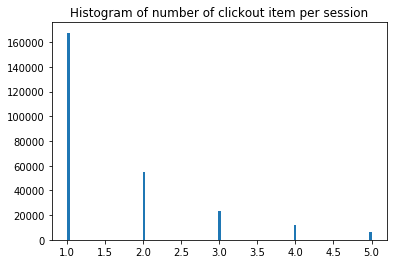

In [116]:
plt.hist(clicks_test.groupby("session_id").size().tolist(), bins='auto', range=(1,5))  # arguments are passed to np.histogram
plt.title("Histogram of number of clickout item per session")
plt.show()

In [46]:
dff

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1970-01-01 00:00:01.541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,00RL8Z82B2Z1,aff3928535f48,1970-01-01 00:00:01.541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,00RL8Z82B2Z1,aff3928535f48,1970-01-01 00:00:01.541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,00RL8Z82B2Z1,aff3928535f48,1970-01-01 00:00:01.541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,00RL8Z82B2Z1,aff3928535f48,1970-01-01 00:00:01.541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
5,00RL8Z82B2Z1,aff3928535f48,1970-01-01 00:00:01.541037532,6,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
6,00RL8Z82B2Z1,aff3928535f48,1970-01-01 00:00:01.541037532,7,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
7,00RL8Z82B2Z1,aff3928535f48,1970-01-01 00:00:01.541037532,8,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
8,00RL8Z82B2Z1,aff3928535f48,1970-01-01 00:00:01.541037542,9,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
9,00RL8Z82B2Z1,aff3928535f48,1970-01-01 00:00:01.541037542,10,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


In [44]:
dff[dff.session_id == "62728015bec05"]

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
15932973,ZYNMLE3MV3LK,62728015bec05,1970-01-01 00:00:01.541544402,1,search for destination,"Paris, France",PT,"Paris, France",desktop,NaN,NaN,NaN
15932974,ZYNMLE3MV3LK,62728015bec05,1970-01-01 00:00:01.541544470,2,interaction item image,6617798,PT,"Paris, France",desktop,NaN,NaN,NaN
15932975,ZYNMLE3MV3LK,62728015bec05,1970-01-01 00:00:01.541544470,3,interaction item image,6617798,PT,"Paris, France",desktop,NaN,NaN,NaN
15932976,ZYNMLE3MV3LK,62728015bec05,1970-01-01 00:00:01.541544480,4,interaction item image,6617798,PT,"Paris, France",desktop,NaN,NaN,NaN
15932977,ZYNMLE3MV3LK,62728015bec05,1970-01-01 00:00:01.541544480,5,interaction item image,6617798,PT,"Paris, France",desktop,NaN,NaN,NaN
15932978,ZYNMLE3MV3LK,62728015bec05,1970-01-01 00:00:01.541544480,6,interaction item image,6617798,PT,"Paris, France",desktop,NaN,NaN,NaN
15932979,ZYNMLE3MV3LK,62728015bec05,1970-01-01 00:00:01.541544480,7,interaction item image,6617798,PT,"Paris, France",desktop,NaN,NaN,NaN
15932980,ZYNMLE3MV3LK,62728015bec05,1970-01-01 00:00:01.541544480,8,interaction item image,6617798,PT,"Paris, France",desktop,NaN,NaN,NaN
15932981,ZYNMLE3MV3LK,62728015bec05,1970-01-01 00:00:01.541544480,9,interaction item image,6617798,PT,"Paris, France",desktop,NaN,NaN,NaN
15932982,ZYNMLE3MV3LK,62728015bec05,1970-01-01 00:00:01.541544480,10,interaction item image,6617798,PT,"Paris, France",desktop,NaN,NaN,NaN


In [39]:
dff.iloc[15932970]['impressions']

'8640|8816|8791|2298566|1811137|8708|67445|8825|8837|4786910|9771628|8748528|2835834|8720|1104798|8750|4916380|8817|8772|6475414|8985292|1024616|4593172|3137058|2861604'

In [43]:
dff["timestamp"] = pd.to_datetime(dff["timestamp"]) 

In [51]:
dff['timestamp'] = pd.to_datetime(dff['timestamp'],unit='s')

In [60]:
s = dff_test.groupby("session_id")

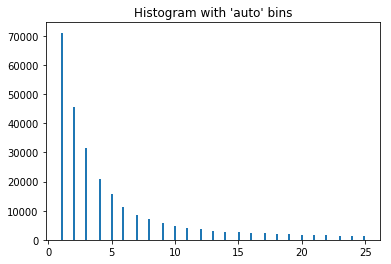

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
rng = np.random.RandomState(10)  # deterministic random data
plt.hist(s.size().tolist(), bins='auto', range=(1,25))  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [70]:
plt.hist?

In [61]:
s.filter(lambda x: len(x) ==1)

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
513,0BZN2KFMHLZF,d9497eeb946dc,1541668916,1,clickout item,NaN,BE,"Hasselt, Belgium",mobile,NaN,39730|133101|39758|7029236|455086|3887112|1070...,90|88|80|80|90|62|65|90|89|75|70|109|165|104|6...
554,0D1XFBRWUX7Z,35e873299a45f,1541586069,1,clickout item,NaN,AU,"Sydney, Australia",mobile,NaN,54865|54803|54953|14211|95510|54838|54794|1484...,163|126|158|177|145|85|107|158|132|189|187|131...
598,0EPVF4QE049Q,11b583578f7f3,1541611766,1,clickout item,NaN,FI,"Seinäjoki, Finland",mobile,NaN,368306|369426|4916202|2045589|1328820|369421|1...,123|152|59|148|105|147|98|70|95|80|140
599,0GY71I4BUBQW,334177bbc6525,1541638087,1,clickout item,NaN,AU,"Rome, Italy",desktop,NaN,17112|1374294|17382|2321776|16895|17056|17108|...,81|95|126|79|186|112|53|112|56|214|142|77|71|1...
600,0H2RFN3FXM5A,e9fa318e4aad0,1541576918,1,clickout item,NaN,IN,"Bengaluru, India",mobile,NaN,1984531|4775794|1400686|930783|2612414|1199716...,37|16|19|50|148|16|157|14|21|19|14|16|16|22|13...
682,0L2CALL26C66,59bfbcb10146d,1541593658,1,clickout item,NaN,PL,"Alicante, Spain",desktop,NaN,8194404|6721|6724|40109|40718|81021|110591|147...,30|36|42|88|46|85|49|57|45|49|56|53|37|63|127|...
801,0ME9OE1GS1Q9,7afb20460a368,1541591150,1,clickout item,NaN,BG,"Prague, Czech Republic",mobile,NaN,13699|100667|13673|111234|14680|920765|80376|8...,61|45|62|32|42|57|54|135|58|79|85|49|69|129|10...
1060,0Q3W4X8HG57M,51c88e49fb6dc,1541612840,1,clickout item,NaN,FR,"Hong Kong, Hong Kong",mobile,NaN,54096|54132|54027|1204728|99423|54125|54146|54...,281|367|313|225|210|398|442|255|381|340|380|30...
1125,0S6ZR5UCAHUK,88fe3fde210f4,1541650657,1,clickout item,NaN,RO,"Sibiu, Romania",desktop,NaN,6919316|7902572|972027|1314825|1306503|7202328...,37|22|80|42|103|50|78|69|19|33|36|28|92|41|22|...
1139,0UCBRUGP6YHU,f57abecfdc90e,1541704893,1,clickout item,NaN,DE,"Antwerp, Belgium",desktop,NaN,8735372|54627|1583829|54776|54685|54640|14856|...,109|154|54|59|98|109|170|131|127|60|134|135|66...


In [55]:
dff[dff.session_id == "fa3a53156ae5c"]

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
16,02HGRBA06ODU,fa3a53156ae5c,2018-11-01 00:07:12,1,interaction item info,3377332,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN
17,02HGRBA06ODU,fa3a53156ae5c,2018-11-01 00:07:23,2,interaction item image,3377332,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN
18,02HGRBA06ODU,fa3a53156ae5c,2018-11-01 00:07:23,3,interaction item image,3377332,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN
19,02HGRBA06ODU,fa3a53156ae5c,2018-11-01 00:07:32,4,interaction item info,3377332,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN
20,02HGRBA06ODU,fa3a53156ae5c,2018-11-01 00:07:47,5,interaction item info,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN
21,02HGRBA06ODU,fa3a53156ae5c,2018-11-01 00:07:57,6,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN
22,02HGRBA06ODU,fa3a53156ae5c,2018-11-01 00:07:57,7,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN
23,02HGRBA06ODU,fa3a53156ae5c,2018-11-01 00:08:07,8,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN
24,02HGRBA06ODU,fa3a53156ae5c,2018-11-01 00:08:07,9,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN
25,02HGRBA06ODU,fa3a53156ae5c,2018-11-01 00:08:07,10,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN
